## ResNet18


In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        # 正常卷积部分，堆叠了两层卷积
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel,
                      kernel_size=3, stride=stride,
                      padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel,
                      kernel_size=3, stride=1,
                      padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )

        # 如果上方卷积没有改变size和channel
        # 则不需要对输入进行变化，故 shortcut为空
        self.shortcut = nn.Sequential()
        # 如果上方卷积改变了size或channel
        # 则使用1x1卷积改变输入的size或channel，使其保持一致
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        # 正常使用卷积操作
        out = self.left(x)
        # 将输入/变换shape后的输入与卷积的输出相加
        out += self.shortcut(x)
        # 经过激活函数后输出
        out = F.relu(out)
        return out

In [3]:
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=4):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        #self.layer5 = self.make_layer(ResidualBlock, 1024, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):  #创建残差块
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
       # print(out.shape)
        out = self.layer1(out)
       # print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        #out = self.layer5(out)
        #print(out.shape)
        out = F.avg_pool2d(out, 4)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        return out

In [4]:
def train_epoch(net, data_loader, device):

    net.train() # 指定当前为训练模式
    train_batch_num = len(data_loader) # 记录共有多少个batch
    total_loss = 0 # 记录Loss
    correct = 0  # 记录共有多少个样本被正确分类
    sample_num = 0 # 记录样本总数

    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        # 将图片放入指定的device中
        data = data.to(device).float()
        # 将图片标签放入指定的device中
        target = target.to(device).long()
        # 将当前梯度清零
        optimizer.zero_grad()
        # 使用模型计算出结果
        output = net(data)
        # 计算损失
        loss = criterion(output, target)
        # 进行反向传播
        loss.backward()
        optimizer.step()
        # 累加Loss
        total_loss += loss.item()
        # 找出每个样本值最大的idx，即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        # 统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        # 累加当前的样本总数
        sample_num += len(prediction)
    # 计算平均的loss与准确率
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

In [5]:
def test_epoch(net, data_loader, device):
    net.eval() # 指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    # 指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [6]:
class MyDataset(torch.utils.data.Dataset): #创建自己的类：MyDataset,这个类是继承的torch.utils.data.Dataset
    def __init__(self, root, datatxt, transform=None, target_transform=None): #初始化一些需要传入的参数

        fh = open(root + datatxt, 'r') #按照传入的路径和txt文本参数，打开这个文本，并读取内容
        imgs = []                      #创建一个名为img的空列表，一会儿用来装东西
        for line in fh:                #按行循环txt文本中的内容
            line = line.rstrip()       # 删除 本行string 字符串末尾的指定字符，这个方法的详细介绍自己查询python
            words = line.split()   #通过指定分隔符对字符串进行切片，默认为所有的空字符，包括空格、换行、制表符等
            imgs.append((words[0]+' '+words[1],int(words[2]))) #把txt里的内容读入imgs列表保存，具体是words几要看txt内容而定
                                        # 很显然，根据我刚才截图所示txt的内容，words[0]是图片信息，words[1]是label
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):    #这个方法是必须要有的，用于按照索引读取每个元素的具体内容
        fn, label = self.imgs[index] #fn是图片path #fn和label分别获得imgs[index]也即是刚才每行中word[0]和word[1]的信息
        img = Image.open(rootMirror+fn).convert('RGB') #按照path读入图片from PIL import Image # 按照路径读取图片

        if self.transform is not None:
            img = self.transform(img) #是否进行transform
        return img,label  #return很关键，return回哪些内容，那么我们在训练时循环读取每个batch时，就能获得哪些内容

    def __len__(self): #这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
        return len(self.imgs)

#根据自己定义的MyDataset来创建数据集！注意是数据集！而不是loader迭代器
root = 'D:\\CS第四学期课程\\毕业设计\\代码\\data\\'
rootMirror = 'D:\\CS第四学期课程\\毕业设计\\代码\\data\\backup\\smaller32\\'
train_data=MyDataset(root, datatxt='train.txt', transform=transforms.ToTensor())
test_data=MyDataset(root, datatxt='test.txt', transform=transforms.ToTensor())
print("妥了")

classes = ('1', '2', '3', '4')
num_classes = 4 # 共4类
epochs = 100 # 训练多少轮
lr = 0.001 # 学习率
batch_size = 16 # batch大小
#device = torch.device("cuda:0") # 指定device为0号GPU,若使用cpu则填写 "cpu"
device = torch.device("cpu")
# 生成dataloader
my_trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
my_testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

妥了


In [7]:
# 初始化模型
net = ResNet(ResidualBlock).to(device)
# 使用多元交叉熵损失
criterion = nn.CrossEntropyLoss()
# 使用Adam优化器
optimizer = optim.Adam(net.parameters(), lr=lr)

In [8]:
import torch, gc
# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# 进行训练
for epoch in range(epochs):
    # 在训练集上训练
    train_loss, train_acc = train_epoch(net, data_loader=my_trainloader, device=device)
    # 在测试集上验证
    test_loss, test_acc = test_epoch(net, data_loader=my_testloader, device=device)
    # 保存各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc:{train_acc} \t"
          f"test_loss:{test_loss:.4f} \t test_acc:{test_acc}")

epoch:0	 train_loss:0.5212 	train_acc:0.8047866205305652 	test_loss:0.2420 	 test_acc:0.9109311740890689
epoch:1	 train_loss:0.2793 	train_acc:0.893598615916955 	test_loss:0.2382 	 test_acc:0.902834008097166
epoch:2	 train_loss:0.1927 	train_acc:0.9253171856978085 	test_loss:0.1317 	 test_acc:0.941970310391363
epoch:3	 train_loss:0.1547 	train_acc:0.9400230680507498 	test_loss:0.1716 	 test_acc:0.9338731443994602
epoch:4	 train_loss:0.1279 	train_acc:0.9492502883506344 	test_loss:0.3374 	 test_acc:0.8717948717948718
epoch:5	 train_loss:0.1147 	train_acc:0.955594002306805 	test_loss:0.2487 	 test_acc:0.9284750337381916
epoch:6	 train_loss:0.1199 	train_acc:0.9544405997693195 	test_loss:0.1329 	 test_acc:0.9473684210526315
epoch:7	 train_loss:0.0912 	train_acc:0.9653979238754326 	test_loss:0.1578 	 test_acc:0.9500674763832658
epoch:8	 train_loss:0.0688 	train_acc:0.972318339100346 	test_loss:0.3045 	 test_acc:0.902834008097166
epoch:9	 train_loss:0.0804 	train_acc:0.9705882352941176 	tes

In [9]:
res = [train_loss_list, train_acc_list, test_loss_list,test_acc_list]

In [10]:
with open('resnet-18.pkl', 'wb') as f:
    pickle.dump(res, f)

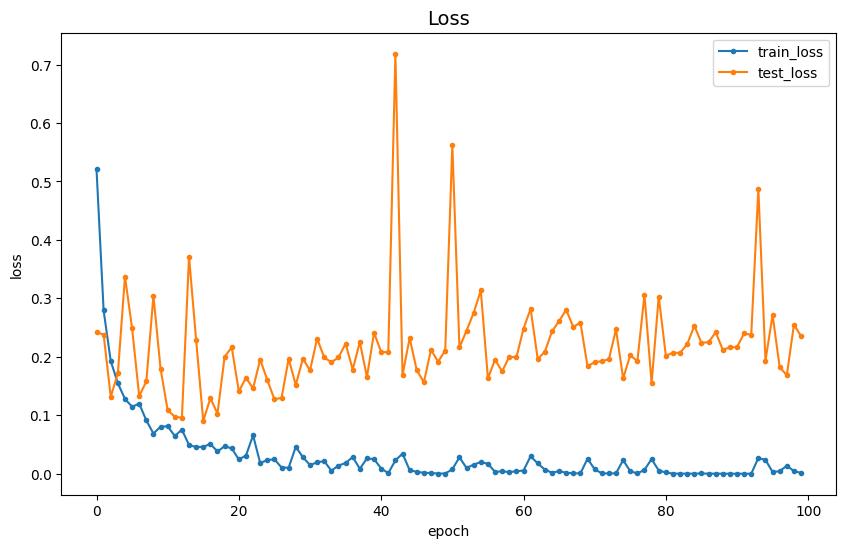

In [11]:
plt.figure(figsize=(10, 6))
train, = plt.plot(train_loss_list,'.-',label='train_loss')
test, = plt.plot(test_loss_list,'.-',label='test_loss')
plt.title("Loss",fontsize=14)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend([train,test],["train_loss", "test_loss"],loc='upper right')
plt.show()

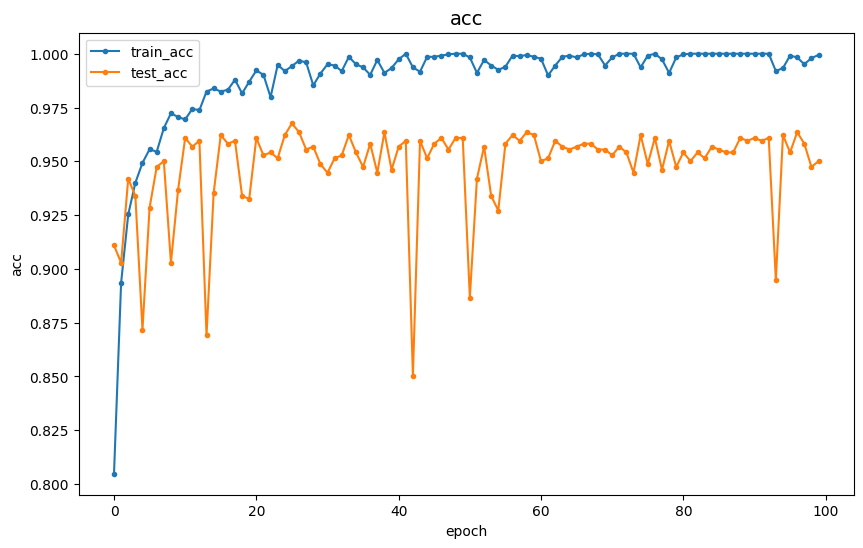

In [12]:
plt.figure(figsize=(10, 6))
train, = plt.plot(train_acc_list,'.-',label='train_acc')
test, = plt.plot(test_acc_list,'.-',label='test_acc')
plt.title("acc",fontsize=14)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend([train,test],["train_acc", "test_acc"],loc='upper left')
plt.show()

In [13]:
max(test_acc_list)

0.9676113360323887